# Walkable City Project

Problem:
I have received a job offer in Seattle and intend to move there, but I am not sure of the neighborhood that is best for me.  I currently live in the downtown area of Chicago and I would like to compare my neighborhood to a similar neighborhood in Seattle.  This would include walkability to grocery stores, proximity to restaurants and bars and access to public transportation.  This system is for anyone moving from Chicago to Seattle.  It could be generalized for the user to select the venue types of most interest and what neighborhood or zip code they are moving from in Chicago.
Data:
The data needed will be the neighborhood names and zip codes for each of the cities (Chicago and Seattle) as well as the latitude and longitude data for the center of each of those neighborhoods.  Using that information, data will be downloaded from FourSquare to access grocery stores, restaurants (including coffee shops), bars and public transportation stops, but all the venue data will be stored for optional analysis.  A DataFrame of all of the neighborhoods will be constructed with each of those neighborhoods and a similarity score will be determined with Cosine Similarity.  After finding the neighborhood most similar, I will create clusters of venues based on lat/long data to find the location of the best place to live near a venue dense area and plot them on a map.


In [1]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
import sklearn

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#Scraping data with beautiful soup
import urllib
import urllib.request
from bs4 import BeautifulSoup

## Importing and cleaning the Chicago Neighborhood data

In [5]:
df = pd.read_csv('https://data.cityofchicago.org/api/views/y6yq-dbs2/rows.csv?accessType=DOWNLOAD')

In [6]:
df['the_geom'] = df['the_geom'].str.strip('MULTIPOLYGON')
df['the_geom'] = df['the_geom'].str.replace('[()]','') 
df.head()

,the_geom,PRI_NEIGH,SEC_NEIGH,SHAPE_AREA,SHAPE_LEN
0,"-87.60670812560372 41.816813771373916, -87.60...",Grand Boulevard,BRONZEVILLE,4.849250e+07,28196.837157
1,"-87.62760697485348 41.8743709778537, -87.6275...",Printers Row,PRINTERS ROW,2.162138e+06,6864.247156
2,"-87.66706868914602 41.888851877695465, -87.66...",United Center,UNITED CENTER,3.252051e+07,23101.363745
3,"-87.65833494805533 41.92166144229183, -87.658...",Sheffield & DePaul,SHEFFIELD & DEPAUL,1.048259e+07,13227.049745
4,"-87.74059567509266 41.8878231689323, -87.7406...",Humboldt Park,HUMBOLDT PARK,1.250104e+08,46126.751351


In [7]:
lat = []
long = []
for i,x in enumerate(df['the_geom']):
    test = pd.Series(df.iloc[i,0].split(','))
    test2 = test.str.lstrip()
    test3 = pd.DataFrame(test2.str.split(' '),columns=['LatLong'])
    #print(test3['LatLong'].str[0])
    lat.append(test3['LatLong'].str[0].astype(float).mean())
    long.append(test3['LatLong'].str[1].astype(float).mean())


In [8]:
d = {'Neighborhood':df['PRI_NEIGH'],'Latitude':long,'Longitude':lat} #Coordinates were reversed
df_chi = pd.DataFrame(data=d)
df_chi.head()

,Neighborhood,Latitude,Longitude
0,Grand Boulevard,41.812351,-87.619113
1,Printers Row,41.871590,-87.629293
2,United Center,41.883024,-87.680273
3,Sheffield & DePaul,41.926751,-87.654054
4,Humboldt Park,41.902500,-87.714318


In [9]:
#Map for checking neighborhoods
chi_lat = 41.921210
chi_long = -87.713928
map_chi = folium.Map(location=[chi_lat, chi_long], zoom_start=11)
# add markers to map
for lat, lng, neighborhood in zip(df_chi['Latitude'], df_chi['Longitude'], df_chi['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chi)  
    
map_chi

## Getting the venue data for Chicago

In [10]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 150 # A default Foursquare API limit value

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
Chi_Venues = getNearbyVenues(names=df_chi['Neighborhood'],
                                   latitudes=df_chi['Latitude'],
                                   longitudes=df_chi['Longitude']
                                  )

In [16]:
# Isolating my neightborhood.  This could be where a selection criteria can be put in so people can compare any Chicago neighborhood
df_hood = Chi_Venues[Chi_Venues['Neighborhood']=='West Loop']

In [17]:
# one hot encoding
hood_onehot = pd.get_dummies(df_hood[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hood_onehot['Neighborhood'] = df_hood['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hood_onehot.columns[-1]] + list(hood_onehot.columns[:-1])
hood_onehot = hood_onehot[fixed_columns]

hood_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,BBQ Joint,Bar,Big Box Store,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Café,Climbing Gym,Cocktail Bar,Coffee Shop,College Gym,Cosmetics Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Fast Food Restaurant,Food Court,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Nightlife Spot,Park,Pet Store,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Snack Place,Southern / Soul Food Restaurant,Sushi Restaurant,Taco Place,Wine Bar,Yoga Studio
2246,West Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2247,West Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2248,West Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2249,West Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2250,West Loop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### This is where we could compare the names of places to major heading, but there are too many, and in accurate sub-headings, so I will compare my neighborhood
#### to those in Seattle without making modifiations. 

In [18]:
hood_grouped = hood_onehot.groupby('Neighborhood').mean().reset_index()
hood_grouped.head()

,Neighborhood,American Restaurant,Art Gallery,BBQ Joint,Bar,Big Box Store,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Café,Climbing Gym,Cocktail Bar,Coffee Shop,College Gym,Cosmetics Shop,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Dog Run,Donut Shop,Fast Food Restaurant,Food Court,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Nightlife Spot,Park,Pet Store,Pizza Place,Portuguese Restaurant,Restaurant,Salad Place,Sandwich Place,Snack Place,Southern / Soul Food Restaurant,Sushi Restaurant,Taco Place,Wine Bar,Yoga Studio
0,West Loop,0.01,0.01,0.02,0.03,0.01,0.01,0.01,0.02,0.02,0.01,0.03,0.01,0.03,0.07,0.01,0.01,0.02,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.03,0.02,0.02,0.01,0.03,0.02,0.05,0.02,0.01,0.01,0.01,0.02,0.03,0.02,0.01,0.02,0.01,0.04,0.01,0.03,0.01,0.02,0.01,0.01,0.02,0.01,0.02,0.01


In [19]:
# Remove the locations that are not as important to me
hood_grouped.drop(['Art Gallery','Cosmetics Shop','Dance Studio','Dog Run','Pet Store','Hotel','Yoga Studio'],axis=1,inplace=True)

## Importing Seattle Neighborhood Data

In [20]:
df_sea = pd.read_csv('Seattle.csv')
df_sea.head()

,Neighborhood
0,Broadview
1,Bitter Lake
2,North Beach
3,Crown Hill
4,Greenwood


In [21]:
latitude = []
longitude = []
for x in df_sea['Neighborhood']:
    address = '{}, Seattle, WA',format(x)
#address = 'Broadview, Seattle, WA'
    #print(address)
    geolocator = Nominatim(user_agent="sea_explorer")
    location = geolocator.geocode(address)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
    

In [22]:
df_sea['lat'] = latitude
df_sea['long'] = longitude
df_sea.head()

,Neighborhood,lat,long
0,Broadview,47.722320,-122.360407
1,Bitter Lake,47.726236,-122.348764
2,North Beach,47.696210,-122.392362
3,Crown Hill,47.694715,-122.371459
4,Greenwood,47.690981,-122.354877


In [23]:
#Cleaning up some missing neighborhoods
df_sea.loc[df_sea['Neighborhood'] =='West Queen Anne','lat':'long'] = [47.634815, -122.370412] 
df_sea.loc[df_sea['Neighborhood'] =='North Queen Anne','lat':'long'] = [47.647287, -122.362249]
df_sea.loc[df_sea['Neighborhood'] =='East Queen Anne','lat':'long'] = [47.637105, -122.349565]
df_sea.loc[df_sea['Neighborhood'] =='Lower Queen Anne','lat':'long'] = [47.624644, -122.356730]
df_sea.loc[df_sea['Neighborhood'] =='Stevens','lat':'long'] = [47.626838, -122.302668]
df_sea.loc[df_sea['Neighborhood'] =='Central Waterfront','lat':'long'] = [47.611172, -122.344840]
df_sea.loc[df_sea['Neighborhood'] =='Miller Park','lat':'long'] = [47.621945, -122.306080]
df_sea.loc[df_sea['Neighborhood'] =='Pike/Pine','lat':'long'] = [47.614101, -122.320871]

In [24]:
geolocator = Nominatim(user_agent="sea_explorer")
location = geolocator.geocode(address)
sea_lat = location.latitude
sea_long = location.longitude

In [25]:
#Map for checking neighborhoods
map_sea = folium.Map(location=[sea_lat, sea_long], zoom_start=11)
# add markers to map
for lat, lng, neighborhood in zip(df_sea['lat'], df_sea['long'], df_sea['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sea)  
    
map_sea

## Getting Seattle Venue Data

In [26]:
Sea_Venues = getNearbyVenues(names=df_sea['Neighborhood'],
                                   latitudes=df_sea['lat'],
                                   longitudes=df_sea['long']
                                  )

In [27]:
# one hot encoding
sea_onehot = pd.get_dummies(Sea_Venues[['Venue Category']], prefix="", prefix_sep="")
sea_onehot.drop('Neighborhood',axis=1,inplace=True)
# add neighborhood column back to dataframe
sea_onehot['Neighborhood'] = Sea_Venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sea_onehot.columns[-1]] + list(sea_onehot.columns[:-1])
sea_onehot = sea_onehot[fixed_columns]

sea_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Science Building,College Theater,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pawn Shop,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Public Art,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Cente

In [28]:
sea_grouped = sea_onehot.groupby('Neighborhood').mean().reset_index()
sea_grouped.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Cafeteria,College Science Building,College Theater,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pawn Shop,Peking Duck Restaurant,Performing Arts Venue,Perfume Shop,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Post Office,Print Shop,Pub,Public Art,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Cente

## Matching Chicago Data to Seattle

In [29]:
chi_cols = hood_grouped.columns
sea_cols = sea_grouped.columns
cols = list(set(chi_cols) & set(sea_cols))

In [30]:
sea_matched = sea_grouped.loc[:,cols]
chi_matched = hood_grouped.loc[:,cols]
print(sea_matched.shape)
sea_matched.head()

(125, 45)


,Gym / Fitness Center,Cocktail Bar,Southern / Soul Food Restaurant,Pizza Place,History Museum,Diner,American Restaurant,Big Box Store,Salad Place,Breakfast Spot,Italian Restaurant,Bar,Taco Place,Climbing Gym,Burger Joint,Wine Bar,Boxing Gym,Mediterranean Restaurant,Café,Gym,Snack Place,Park,Martial Arts School,Food Court,Ice Cream Shop,Mexican Restaurant,New American Restaurant,Restaurant,Brewery,Japanese Restaurant,Donut Shop,Greek Restaurant,Sushi Restaurant,BBQ Joint,Coffee Shop,Korean Restaurant,Neighborhood,Deli / Bodega,Grocery Store,Market,Sandwich Place,Bookstore,Dessert Shop,Nightlife Spot,Fast Food Restaurant
0,0.01,0.00,0.0,0.030000,0.000000,0.01,0.00,0.0,0.0,0.01,0.000000,0.03,0.0,0.0,0.01,0.0,0.0,0.02,0.05,0.00,0.0,0.020000,0.0,0.00,0.010000,0.020000,0.01,0.01,0.02,0.01,0.000000,0.0,0.01,0.0,0.090000,0.04,Adams,0.03,0.02,0.000000,0.020000,0.02,0.02,0.0,0.0
1,0.00,0.00,0.0,0.033333,0.033333,0.00,0.00,0.0,0.0,0.00,0.033333,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.033333,0.0,0.00,0.033333,0.033333,0.00,0.00,0.00,0.00,0.033333,0.0,0.00,0.0,0.066667,0.00,Alki Point,0.00,0.00,0.033333,0.033333,0.00,0.00,0.0,0.0
2,0.00,0.00,0.0,0.000000,0.000000,0.00,0.00,0.0,0.0,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.250000,0.0,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.0,0.00,0.0,0.000000,0.00,Arbor Heights,0.00,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0
3,0.00,0.00,0.0,0.010000,0.010000,0.00,0.02,0.0,0.0,0.00,0.000000,0.02,0.0,0.0,0.00,0.0,0.0,0.00,0.02,0.00,0.0,0.010000,0.0,0.01,0.000000,0.010000,0.00,0.00,0.01,0.01,0.010000,0.0,0.00,0.0,0.000000,0.01,Atlantic,0.01,0.01,0.000000,0.020000,0.01,0.02,0.0,0.0
4,0.00,0.03,0.0,0.020000,0.000000,0.00,0.00,0.0,0.0,0.01,0.020000,0.02,0.0,0.0,0.04,0.0,0.0,0.01,0.00,0.02,0.0,0.020000,0.0,0.00,0.050000,0.020000,0.01,0.00,0.00,0.00,0.010000,0.0,0.02,0.0,0.080000,0.01,Ballard,0.00,0.00,0.000000,0.020000,0.01,0.02,0.0,0.0


In [31]:
print(chi_matched.shape)
chi_matched.head()

(1, 45)


,Gym / Fitness Center,Cocktail Bar,Southern / Soul Food Restaurant,Pizza Place,History Museum,Diner,American Restaurant,Big Box Store,Salad Place,Breakfast Spot,Italian Restaurant,Bar,Taco Place,Climbing Gym,Burger Joint,Wine Bar,Boxing Gym,Mediterranean Restaurant,Café,Gym,Snack Place,Park,Martial Arts School,Food Court,Ice Cream Shop,Mexican Restaurant,New American Restaurant,Restaurant,Brewery,Japanese Restaurant,Donut Shop,Greek Restaurant,Sushi Restaurant,BBQ Joint,Coffee Shop,Korean Restaurant,Neighborhood,Deli / Bodega,Grocery Store,Market,Sandwich Place,Bookstore,Dessert Shop,Nightlife Spot,Fast Food Restaurant
0,0.02,0.03,0.01,0.04,0.01,0.01,0.01,0.01,0.01,0.02,0.05,0.03,0.01,0.01,0.01,0.02,0.01,0.02,0.03,0.02,0.01,0.02,0.01,0.01,0.02,0.03,0.02,0.03,0.02,0.02,0.01,0.05,0.02,0.02,0.07,0.01,West Loop,0.03,0.03,0.01,0.02,0.01,0.01,0.01,0.01


In [32]:
chi_input = np.array(chi_matched.drop('Neighborhood',axis=1))
x = chi_input.reshape(1,-1)
sea_array_in = sea_matched.drop('Neighborhood',axis = 1)
df_out = pd.DataFrame(data=sea_matched['Neighborhood'])
Similarity = []
for i,z in sea_array_in.iterrows(): 
    sea_input = np.array(z)
    y = sea_input.reshape(1,-1)
    Similarity.append(sklearn.metrics.pairwise.cosine_similarity(x, y))
#Similarity

### Finding the best neighborhood

In [33]:
sea_matched['Similarity'] = np.nan
for i,j in enumerate(Similarity):
    Similarity[i] = j[0][0]
    sea_matched.loc[i,'Similarity']=(j[0][0])
df_out['Similarity'] = Similarity

In [34]:
df_cluster = pd.concat([chi_matched,sea_matched])
df_cluster.set_index('Neighborhood',inplace=True)
df_cluster.drop('Similarity',axis=1,inplace=True)
df_cluster.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,American Restaurant,BBQ Joint,Bar,Big Box Store,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Café,Climbing Gym,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Fast Food Restaurant,Food Court,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Nightlife Spot,Park,Pizza Place,Restaurant,Salad Place,Sandwich Place,Snack Place,Southern / Soul Food Restaurant,Sushi Restaurant,Taco Place,Wine Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
West Loop,0.01,0.02,0.03,0.01,0.01,0.01,0.02,0.02,0.01,0.03,0.01,0.03,0.070000,0.03,0.01,0.01,0.010000,0.01,0.01,0.05,0.03,0.02,0.02,0.010000,0.020000,0.050000,0.02,0.01,0.010000,0.01,0.02,0.030000,0.02,0.01,0.020000,0.040000,0.03,0.01,0.020000,0.01,0.01,0.02,0.01,0.02
Adams,0.00,0.00,0.03,0.00,0.02,0.00,0.01,0.02,0.01,0.05,0.00,0.00,0.090000,0.03,0.02,0.01,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.000000,0.010000,0.000000,0.01,0.04,0.000000,0.00,0.02,0.020000,0.01,0.00,0.020000,0.030000,0.01,0.00,0.020000,0.00,0.00,0.01,0.00,0.00
Alki Point,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.066667,0.00,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,0.00,0.033333,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00
Arbor Heights,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.250000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00
Atlantic,0.02,0.00,0.02,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.000000,0.01,0.02,0.00,0.010000,0.00,0.01,0.00,0.01,0.00,0.00,0.010000,0.000000,0.000000,0.01,0.01,0.000000,0.00,0.00,0.010000,0.00,0.00,0.010000,0.010000,0.00,0.00,0.020000,0.00,0.00,0.00,0.00,0.00


### Determine clusters of similar neighborhoods to give additional options

In [35]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 3, 0, 1, 0, 1, 0, 3])

In [36]:
df_cluster['Cluster'] = kmeans.labels_
df_cluster.head()

,American Restaurant,BBQ Joint,Bar,Big Box Store,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Café,Climbing Gym,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Fast Food Restaurant,Food Court,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Nightlife Spot,Park,Pizza Place,Restaurant,Salad Place,Sandwich Place,Snack Place,Southern / Soul Food Restaurant,Sushi Restaurant,Taco Place,Wine Bar,Cluster
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
West Loop,0.01,0.02,0.03,0.01,0.01,0.01,0.02,0.02,0.01,0.03,0.01,0.03,0.070000,0.03,0.01,0.01,0.010000,0.01,0.01,0.05,0.03,0.02,0.02,0.010000,0.020000,0.050000,0.02,0.01,0.010000,0.01,0.02,0.030000,0.02,0.01,0.020000,0.040000,0.03,0.01,0.020000,0.01,0.01,0.02,0.01,0.02,1
Adams,0.00,0.00,0.03,0.00,0.02,0.00,0.01,0.02,0.01,0.05,0.00,0.00,0.090000,0.03,0.02,0.01,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.000000,0.010000,0.000000,0.01,0.04,0.000000,0.00,0.02,0.020000,0.01,0.00,0.020000,0.030000,0.01,0.00,0.020000,0.00,0.00,0.01,0.00,0.00,1
Alki Point,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.066667,0.00,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,0.00,0.033333,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,1
Arbor Heights,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.250000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,3
Atlantic,0.02,0.00,0.02,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.00,0.00,0.000000,0.01,0.02,0.00,0.010000,0.00,0.01,0.00,0.01,0.00,0.00,0.010000,0.000000,0.000000,0.01,0.01,0.000000,0.00,0.00,0.010000,0.00,0.00,0.010000,0.010000,0.00,0.00,0.020000,0.00,0.00,0.00,0.00,0.00,0


In [37]:
df_cluster_hoods = df_cluster[df_cluster['Cluster']==df_cluster.loc['West Loop','Cluster']]
df_cluster_hoods.head()

,American Restaurant,BBQ Joint,Bar,Big Box Store,Bookstore,Boxing Gym,Breakfast Spot,Brewery,Burger Joint,Café,Climbing Gym,Cocktail Bar,Coffee Shop,Deli / Bodega,Dessert Shop,Diner,Donut Shop,Fast Food Restaurant,Food Court,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,New American Restaurant,Nightlife Spot,Park,Pizza Place,Restaurant,Salad Place,Sandwich Place,Snack Place,Southern / Soul Food Restaurant,Sushi Restaurant,Taco Place,Wine Bar,Cluster
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
West Loop,0.01,0.02,0.03,0.01,0.01,0.01,0.02,0.02,0.01,0.03,0.01,0.03,0.070000,0.03,0.01,0.01,0.010000,0.01,0.01,0.05,0.03,0.02,0.02,0.010000,0.020000,0.050000,0.02,0.01,0.010000,0.01,0.02,0.030000,0.02,0.01,0.020000,0.040000,0.03,0.01,0.020000,0.01,0.01,0.02,0.01,0.02,1
Adams,0.00,0.00,0.03,0.00,0.02,0.00,0.01,0.02,0.01,0.05,0.00,0.00,0.090000,0.03,0.02,0.01,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.000000,0.010000,0.000000,0.01,0.04,0.000000,0.00,0.02,0.020000,0.01,0.00,0.020000,0.030000,0.01,0.00,0.020000,0.00,0.00,0.01,0.00,0.00,1
Alki Point,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.066667,0.00,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,0.00,0.033333,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.00,0.00,0.033333,0.033333,0.00,0.00,0.033333,0.00,0.00,0.00,0.00,0.00,1
Ballard,0.00,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.04,0.00,0.00,0.03,0.080000,0.00,0.02,0.00,0.010000,0.00,0.00,0.00,0.00,0.02,0.00,0.000000,0.050000,0.020000,0.00,0.01,0.000000,0.00,0.01,0.020000,0.01,0.00,0.020000,0.020000,0.00,0.00,0.020000,0.00,0.00,0.02,0.00,0.00,1
Belltown,0.01,0.00,0.04,0.00,0.01,0.00,0.03,0.02,0.00,0.00,0.00,0.04,0.050000,0.01,0.01,0.00,0.020000,0.00,0.00,0.00,0.00,0.02,0.00,0.000000,0.000000,0.030000,0.01,0.01,0.010000,0.00,0.00,0.010000,0.02,0.00,0.000000,0.020000,0.02,0.01,0.000000,0.00,0.00,0.04,0.00,0.01,1


In [38]:
wl_cluster = list(df_cluster_hoods.index)

In [39]:
sea_similar = pd.DataFrame(data = (sea_matched['Similarity']), columns = ['Similarity'])
sea_similar['Neighborhood'] = sea_matched['Neighborhood']
sea_similar = sea_similar[sea_similar['Neighborhood'].isin(wl_cluster)]
sea_similar.sort_values(by=['Similarity'],axis=0,ascending=False,inplace=True)
sea_similar.head()

,Similarity,Neighborhood
69,0.813224,Miller Park
85,0.812543,Pike/Pine
108,0.804444,Stevens
121,0.781003,Westlake
12,0.776534,Broadway


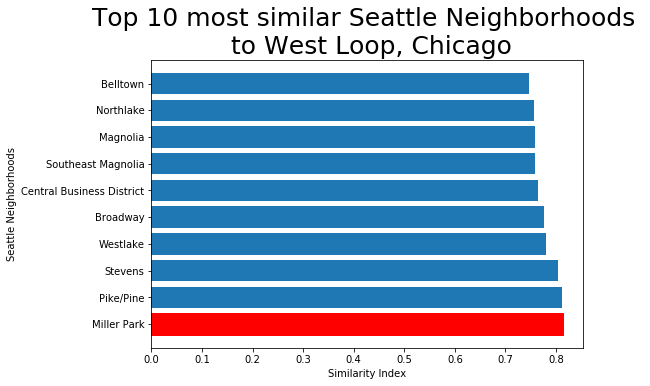

In [40]:
df_barplot = sea_similar.head(10)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
barlist = ax.barh(df_barplot['Neighborhood'],df_barplot['Similarity'])

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
barlist[0].set_color('r')
ax.set_ylabel('Seattle Neighborhoods')
ax.set_xlabel('Similarity Index')
ax.set_title('Top 10 most similar Seattle Neighborhoods \n to West Loop, Chicago')
plt.show()

In [41]:
Best_Hood = df_out.iloc[df_out[['Similarity']].idxmax(),0].astype(str)
Best_Hood

69    Miller Park
Name: Neighborhood, dtype: object

# The Winner is Miller Park!

In [42]:
MillerPark_Venues = Sea_Venues[Sea_Venues.loc[:,'Neighborhood']=='Miller Park']
MillerPark_Venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
7770,Miller Park,47.621945,-122.30608,Hello Robin,47.623985,-122.307240,Bakery
7771,Miller Park,47.621945,-122.30608,Cone & Steiner,47.624105,-122.307253,Gourmet Shop
7772,Miller Park,47.621945,-122.30608,Two Doors Down,47.620051,-122.301398,American Restaurant
7773,Miller Park,47.621945,-122.30608,Tallulah's,47.624313,-122.307220,Bar
7774,Miller Park,47.621945,-122.30608,Monsoon,47.624791,-122.307350,Vietnamese Restaurant


In [43]:
wl_graph = chi_matched.drop('Neighborhood',axis=1).transpose()
wl_graph['Miller Park'] = pd.Series(sea_array_in.iloc[69,:])
wl_graph.columns = ['West Loop', 'Miller Park']
wl_graph.head()

,West Loop,Miller Park
Gym / Fitness Center,0.02,0.010989
Cocktail Bar,0.03,0.032967
Southern / Soul Food Restaurant,0.01,0.010989
Pizza Place,0.04,0.000000
History Museum,0.01,0.000000


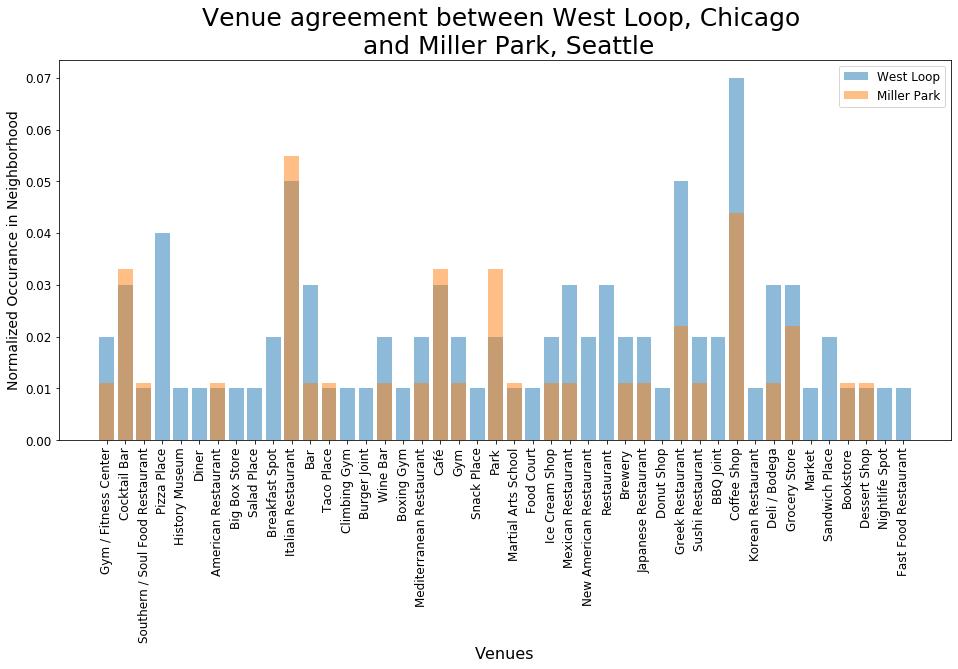

In [44]:
plt.figure(figsize=(16,7))
plt.bar(wl_graph.index,wl_graph['West Loop'],alpha=0.5,label='West Loop')
plt.bar(wl_graph.index,wl_graph['Miller Park'],alpha=0.5,label='Miller Park')
plt.xlabel('Venues',size = 16)
plt.ylabel('Normalized Occurance in Neighborhood',size = 14)
plt.title('Venue agreement between West Loop, Chicago \n and Miller Park, Seattle')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Map for plotting venues
mp_loc = df_sea[df_sea['Neighborhood']=='Miller Park']
map_mp = folium.Map(location=[mp_loc['lat'], mp_loc['long']], zoom_start=15)
# add markers to map
for lat, lng, cat in zip(MillerPark_Venues['Venue Latitude'], MillerPark_Venues['Venue Longitude'], MillerPark_Venues['Venue']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#00ff00',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mp)  
    
map_mp

#### The venues around Miller Park